In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition/download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xuetingggg
Your Kaggle Key: ··········


100%|██████████| 1.26G/1.26G [00:08<00:00, 153MB/s]


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ML/train.csv')
valid = pd.read_csv('/content/drive/MyDrive/ML/valid.csv')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max([len(label) for label in train['IDENTITY'].values])
characters = set(char for label in train['IDENTITY'].values for char in label)

In [ ]:
tok = Tokenizer(num_words = len(characters), char_level = True)
tok.fit_on_texts(train['IDENTITY'].values)
tok.word_index

{'a': 1,
 'b': 19,
 'c': 13,
 'd': 18,
 'e': 2,
 'g': 16,
 'h': 9,
 'i': 6,
 'l': 3,
 'm': 5,
 'n': 4,
 'o': 8,
 'p': 15,
 'q': 20,
 'r': 11,
 's': 10,
 't': 7,
 'u': 12,
 'x': 14,
 'z': 17}

In [ ]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00006.jpg,lucie
1,TRAIN_00011.jpg,emma
2,TRAIN_00020.jpg,romain
3,TRAIN_00027.jpg,thomas
4,TRAIN_00069.jpg,ines


In [ ]:
def preprocess(image_path, label, index, data):
    
    img_dir = image_path + data.loc[index, 'FILENAME']
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        
    img = cv2.resize(img,(200, 50), interpolation = cv2.INTER_AREA) # resize image to a height of 200 and width of 50
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) / 255 # rotate image
    
    label_sequence = tok.texts_to_sequences([label]) # tokenize the names
    pad = pad_sequences(label_sequence, maxlen = max_length, padding = 'post')[0]
    
    return img,pad

In [ ]:
img, label = preprocess('/content/handwriting-recognition/train_v2/train/', 'lucie', 0, train)

In [ ]:
label

array([ 3, 12, 13,  6,  2,  0,  0,  0,  0], dtype=int32)

In [ ]:
X_train = []
Y_train = []
train_label_len = []

for i in range(len(train)):
    
    path = '/content/handwriting-recognition/train_v2/train/'
    label = train.loc[i, 'IDENTITY']
    train_label_len.append(len(label))
    img, y = preprocess(path, label, i, train)
    img = np.expand_dims(img, axis = 2)
    X_train.append(img)
    Y_train.append(y)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)
train_label_len = np.array(train_label_len)

In [ ]:
X_valid = []
Y_valid = []
valid_label_len = []

for i in range(len(valid)):
    
    path = '/content/handwriting-recognition/validation_v2/validation/'
    label = valid.loc[i, 'IDENTITY']
    valid_label_len.append(len(label))
    img, y = preprocess(path, label, i, valid)
    img = np.expand_dims(img, axis = 2)
    X_valid.append(img)
    Y_valid.append(y)
    
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)
valid_label_len = np.array(valid_label_len)

In [ ]:
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)

(34306, 200, 50, 1) (34306, 9) (4335, 200, 50, 1) (4335, 9)


In [ ]:
train_input_len = np.ones([len(train), 1]) * 48
valid_input_len = np.ones([len(valid), 1]) * 48

In [ ]:
from keras import backend as K
from tensorflow.keras import layers
from tensorflow import keras

def ctc_loss(args):
    labels, y_pred, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
input_img = layers.Input(shape=(200, 50, 1), name="image")
labels = layers.Input(name="label", shape=(max_length,))
input_length = layers.Input(name='input_length', shape=(1,))
label_length = layers.Input(name='label_length', shape=(1,))

x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1",)(input_img)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)


x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2",)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)

x = layers.Reshape(target_shape=(50,768), name="reshape")(x)
x = layers.Dense(64, activation="relu", name="dense1")(x)
x = layers.Dropout(0.2)(x)


x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)

# Output layer
y_pred = layers.Dense(len(characters) + 1, activation="softmax", name="output")(x)


loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, y_pred, input_length, label_length])


# Define the model
model = keras.models.Model(inputs=[input_img, labels, input_length, label_length], 
                           outputs=loss_out,
                           name="CRNN_model")

In [ ]:
opt = keras.optimizers.Adam()

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "CRNN_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']         

In [ ]:
epochs = 20

# Train the model
history = model.fit(
    x = (X_train, Y_train, train_input_len, train_label_len),
    y = np.zeros([len(train)]),
    validation_data = ([X_valid, Y_valid, valid_input_len, valid_label_len], np.zeros([len(valid)])),
    epochs=epochs,
    batch_size = 30
)

Epoch 1/20
1144/1144 [==============================] - 49s 37ms/step - loss: 13.5916 - accuracy: 0.0000e+00 - val_loss: 12.0184 - val_accuracy: 0.0000e+00
Epoch 2/20
1144/1144 [==============================] - 41s 36ms/step - loss: 7.5606 - accuracy: 0.0119 - val_loss: 3.9034 - val_accuracy: 0.0927
Epoch 3/20
1144/1144 [==============================] - 41s 36ms/step - loss: 2.6016 - accuracy: 0.3145 - val_loss: 1.1959 - val_accuracy: 0.6973
Epoch 4/20
1144/1144 [==============================] - 42s 37ms/step - loss: 1.1781 - accuracy: 0.7157 - val_loss: 0.7823 - val_accuracy: 0.8404
Epoch 5/20
1144/1144 [==============================] - 41s 36ms/step - loss: 0.8185 - accuracy: 0.8240 - val_loss: 0.5708 - val_accuracy: 0.8997
Epoch 6/20
1144/1144 [==============================] - 42s 36ms/step - loss: 0.7015 - accuracy: 0.8575 - val_loss: 0.4874 - val_accuracy: 0.9181
Epoch 7/20
1144/1144 [==============================] - 41s 36ms/step - loss: 0.5514 - accuracy: 0.8898 - val_loss

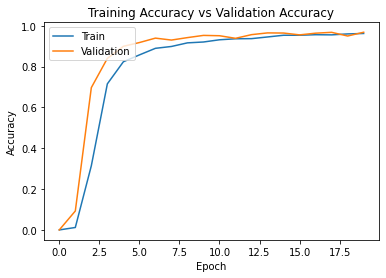

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

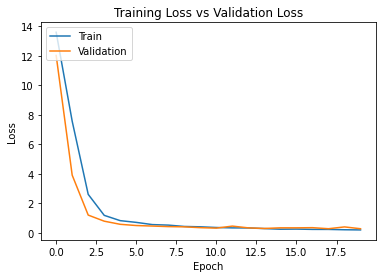

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="output").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [ ]:
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        decoded = tok.sequences_to_texts([res.numpy()])
        output_text.append(decoded)
    return output_text

In [ ]:
preds = prediction_model.predict(X_valid)
pred_texts = decode_predictions(preds)

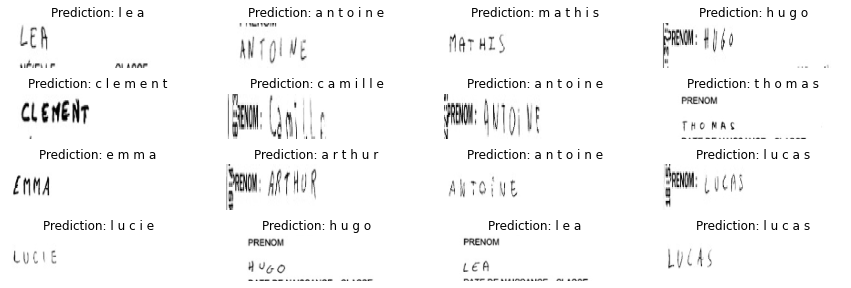

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = X_valid[i]
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_texts[i][0]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()